# Lab 5

Objectives:
- use multiple sources
- join DataFrames
- conditional filling
- plot timeseries data

In [1]:
from pyspark.sql import SparkSession
spark =  SparkSession.builder.appName('Lab5').getOrCreate()

## Dataset Information File
The *stock_data* folder contains 3 files:
- indexData -> raw data 
- indexInfo -> information about the indices and their currency
- indexProcessed -> a processed version of the dataset with an additional column: the Close price in US dollars

We would like to process our raw data in order to transform all values in their US dollar corresponding value

In [2]:
info_df = spark.read.csv("stock_data/indexInfo.csv", header=True, inferSchema=True)
info_df.printSchema()
info_df.show(info_df.count())

root
 |-- Region: string (nullable = true)
 |-- Exchange: string (nullable = true)
 |-- Index: string (nullable = true)
 |-- Currency: string (nullable = true)

+-------------+--------------------+---------+--------+
|       Region|            Exchange|    Index|Currency|
+-------------+--------------------+---------+--------+
|United States|New York Stock Ex...|      NYA|     USD|
|United States|              NASDAQ|     IXIC|     USD|
|    Hong Kong|Hong Kong Stock E...|      HSI|     HKD|
|        China|Shanghai Stock Ex...|000001.SS|     CNY|
|        Japan|Tokyo Stock Exchange|     N225|     JPY|
|       Europe|            Euronext|     N100|     EUR|
|        China|Shenzhen Stock Ex...|399001.SZ|     CNY|
|       Canada|Toronto Stock Exc...|   GSPTSE|     CAD|
|        India|National Stock Ex...|     NSEI|     INR|
|      Germany|Frankfurt Stock E...|    GDAXI|     EUR|
|        Korea|      Korea Exchange|     KS11|     KRW|
|  Switzerland|  SIX Swiss Exchange|     SSMI|     CHF|

## Currency history
In order to transform the currency for a given index, we need the corresponding exchange rate from that date. 
We can download a historical currency exchange rate from here: 
- https://www.kaggle.com/datasets/dhruvildave/currency-exchange-rates

We can place it in your stock_data folder. 

In [3]:
forex_df = spark.read.csv("stock_data/forex.csv", header=True, inferSchema=True)
forex_df.printSchema()
print(forex_df.count(), "rows in this dataset")
forex_df.orderBy('Date').show(10)

root
 |-- slug: string (nullable = true)
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- currency: string (nullable = true)

1453035 rows in this dataset
+-------+----------+----------+----------+----------+----------+--------+
|   slug|      date|      open|      high|       low|     close|currency|
+-------+----------+----------+----------+----------+----------+--------+
|JPY/USD|1996-10-30|  0.008744|  0.008802|  0.008735|  0.008758|     USD|
|USD/JPY|1996-10-30|114.370003|114.480003|113.610001|    114.18|     JPY|
|JPY/USD|1996-11-01|  0.008811|  0.008811|  0.008811|  0.008811|     USD|
|USD/JPY|1996-11-01|     113.5|     113.5|     113.5|     113.5|     JPY|
|JPY/USD|1996-11-04|  0.008828|  0.008853|  0.008773|  0.008781|     USD|
|USD/JPY|1996-11-04|113.279999|113.980003|112.949997|113.879997|     JPY|
|JPY/USD|1996-11-05|  0.008794|  0.008814|  0

### PySpark Functions
There is a common pattern to import the functions module as **F** and then use **F.function**. In the following cell we use:
- concat -> to concatenate two string values
- lit -> to inform Spark that we want a **literal** string, and not the name of a Column.

We concatenate the literal value **USD/** with the corresponding value in the **Currency** column.
This column will be used as a **join** column in the following cell. 

In [4]:
from pyspark.sql import functions as F
info_df = info_df.withColumn('slug', F.concat(F.lit('USD/'), info_df.Currency))

info_df.show()

+-------------+--------------------+---------+--------+-------+
|       Region|            Exchange|    Index|Currency|   slug|
+-------------+--------------------+---------+--------+-------+
|United States|New York Stock Ex...|      NYA|     USD|USD/USD|
|United States|              NASDAQ|     IXIC|     USD|USD/USD|
|    Hong Kong|Hong Kong Stock E...|      HSI|     HKD|USD/HKD|
|        China|Shanghai Stock Ex...|000001.SS|     CNY|USD/CNY|
|        Japan|Tokyo Stock Exchange|     N225|     JPY|USD/JPY|
|       Europe|            Euronext|     N100|     EUR|USD/EUR|
|        China|Shenzhen Stock Ex...|399001.SZ|     CNY|USD/CNY|
|       Canada|Toronto Stock Exc...|   GSPTSE|     CAD|USD/CAD|
|        India|National Stock Ex...|     NSEI|     INR|USD/INR|
|      Germany|Frankfurt Stock E...|    GDAXI|     EUR|USD/EUR|
|        Korea|      Korea Exchange|     KS11|     KRW|USD/KRW|
|  Switzerland|  SIX Swiss Exchange|     SSMI|     CHF|USD/CHF|
|       Taiwan|Taiwan Stock Exch...|    

## Joining the datasets
We would like to use the exchange rate corresponding to each index. To achieve this we can use a **inner join** operation. 
The **slug** column will be used to join the rows of the two DataFrames. 
The **inner** join will only extract rows which match the join expression. 

In [5]:
forex_join_df = forex_df.join(info_df, forex_df.slug == info_df.slug, "inner")
print(forex_df.count(), forex_join_df.count())
forex_join_df.show(10)
forex_join_df.groupBy('Index').count().show()

1453035 57728
+-------+----------+----------+----------+----------+----------+--------+------+--------------------+-----+--------+-------+
|   slug|      date|      open|      high|       low|     close|currency|Region|            Exchange|Index|Currency|   slug|
+-------+----------+----------+----------+----------+----------+--------+------+--------------------+-----+--------+-------+
|USD/JPY|1996-10-30|114.370003|114.480003|113.610001|    114.18|     JPY| Japan|Tokyo Stock Exchange| N225|     JPY|USD/JPY|
|USD/JPY|1996-11-01|     113.5|     113.5|     113.5|     113.5|     JPY| Japan|Tokyo Stock Exchange| N225|     JPY|USD/JPY|
|USD/JPY|1996-11-04|113.279999|113.980003|112.949997|113.879997|     JPY| Japan|Tokyo Stock Exchange| N225|     JPY|USD/JPY|
|USD/JPY|1996-11-05|113.709999|114.330002|113.449997|    114.25|     JPY| Japan|Tokyo Stock Exchange| N225|     JPY|USD/JPY|
|USD/JPY|1996-11-06|114.230003|    114.68|113.650002|113.949997|     JPY| Japan|Tokyo Stock Exchange| N225|    

### Losing data
Notice there was no match for the *USD/USD* slug. We will fill this value with 1.0 later. 
For now, we will extract only the important columns from the join DataFrame. 

In [6]:
from pyspark.sql import functions as F
forex_join_df = forex_join_df.select([F.col('date').alias('forex_date'), F.col('Index').alias('join_index'), F.col('close').alias('rate')])
forex_join_df.show(10)

+----------+----------+----------+
|forex_date|join_index|      rate|
+----------+----------+----------+
|1996-10-30|      N225|    114.18|
|1996-11-01|      N225|     113.5|
|1996-11-04|      N225|113.879997|
|1996-11-05|      N225|    114.25|
|1996-11-06|      N225|113.949997|
|1996-11-08|      N225|111.739998|
|1996-11-11|      N225|111.120003|
|1996-11-12|      N225|111.330002|
|1996-11-13|      N225|111.349998|
|1996-11-15|      N225|111.050003|
+----------+----------+----------+
only showing top 10 rows



Finally, we read the historical stock data

In [7]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType
columns = []
columns.append(StructField('Index', StringType(), True))
columns.append(StructField('Date', DateType(), True))
columns.append(StructField('Open', DoubleType(), True))
columns.append(StructField('High', DoubleType(), True))
columns.append(StructField('Low', DoubleType(), True))
columns.append(StructField('Close', DoubleType(), True))
columns.append(StructField('Adj Close', DoubleType(), True))
columns.append(StructField('Volume', DoubleType(), True))
schema = StructType(fields=columns)
history_df = spark.read.csv("stock_data/indexData.csv", header=True, schema=schema)

In [8]:
from pyspark.sql import functions as F
history_df.groupBy('Index').agg(F.min('Date')).show()

+---------+----------+
|    Index| min(Date)|
+---------+----------+
|   GSPTSE|1979-06-29|
|      NYA|1965-12-31|
|      HSI|1986-12-31|
|399001.SZ|1997-08-22|
|     IXIC|1971-02-05|
|000001.SS|1997-07-02|
|     NSEI|2007-09-17|
|     TWII|1997-07-02|
|     N225|1965-01-05|
|  J203.JO|2012-02-08|
|     KS11|1996-12-11|
|     SSMI|1990-11-09|
|    GDAXI|1987-12-30|
|     N100|1999-12-31|
+---------+----------+



## Joining the historical stock data with the currency data
Notes:
- currency data lost the USD stocks
- currency dates may be missing for a given stock date

Thus, we must use an **outer join**, which will keep the rows that do not have a match in the other DataFrame, presenting NULL values for these columns. 

In [9]:
history_join_df = history_df.join(forex_join_df, (history_df.Index == forex_join_df.join_index) & (history_df.Date == forex_join_df.forex_date), "outer")

In the DataFrame below we can observe missing values for the forex price on several dates. Moreover, there are more rows than in the original indexData dataset. 

In [10]:
history_join_df.show(10)
history_join_df.count()

+---------+----------+-----------+-----------+-----------+-----------+-----------+------+----------+----------+----+
|    Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume|forex_date|join_index|rate|
+---------+----------+-----------+-----------+-----------+-----------+-----------+------+----------+----------+----+
|000001.SS|1997-07-02|1255.909058|1261.571045|1147.331055|1199.061035|1199.061035|   0.0|      NULL|      NULL|NULL|
|000001.SS|1997-07-03|1194.676025|1194.676025|1149.939941|1150.623047|1150.623047|   0.0|      NULL|      NULL|NULL|
|000001.SS|1997-07-15|       NULL|       NULL|       NULL|       NULL|       NULL|  NULL|      NULL|      NULL|NULL|
|000001.SS|1997-07-16|1201.594971| 1204.85498|1184.444946| 1190.82605| 1190.82605|   0.0|      NULL|      NULL|NULL|
|000001.SS|1997-07-21|1215.838989|1218.480957|   1188.875|1193.525024|1193.525024|   0.0|      NULL|      NULL|NULL|
|000001.SS|1997-07-22|1189.118042|1208.261963|1163.468018|1208.2

118479

In [11]:
history_join_df.where(history_join_df.Index.isNull()).show(10)

+-----+----+----+----+----+-----+---------+------+----------+----------+------+
|Index|Date|Open|High| Low|Close|Adj Close|Volume|forex_date|join_index|  rate|
+-----+----+----+----+----+-----+---------+------+----------+----------+------+
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2006-01-03| 000001.SS|8.0662|
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2006-01-30| 000001.SS| 8.062|
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2006-02-01| 000001.SS| 8.062|
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2007-01-02| 000001.SS| 7.806|
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2007-02-22| 000001.SS|7.7402|
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2007-05-01| 000001.SS|7.6955|
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2007-10-02| 000001.SS| 7.496|
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2007-12-31| 000001.SS|7.2941|
| NULL|NULL|NULL|NULL|NULL| NULL|     NULL|  NULL|2008-02-12| 000001.SS|  7.18|
| NULL|NULL|NULL|NULL|NULL| NULL|     NU

We drop the rows which have a missing Index.
This means that there are dates in the currency file that do not match the stock data dates. 

In [12]:
history_join_df = history_join_df.na.drop(subset=['Index'])
history_join_df.count()

112457

Now it's better, we have exactly the number of rows as in the original dataset. 

We can check how many values are null for each index. 

In [13]:
history_join_df.where(history_join_df.rate.isNull()).show(10)
history_join_df.where(history_join_df.rate.isNull()).groupBy('Index').count().show()

+-----+----------+----------+----------+----------+----------+----------+------+----------+----------+----+
|Index|      Date|      Open|      High|       Low|     Close| Adj Close|Volume|forex_date|join_index|rate|
+-----+----------+----------+----------+----------+----------+----------+------+----------+----------+----+
|  NYA|1966-03-23|511.980011|511.980011|511.980011|511.980011|511.980011|   0.0|      NULL|      NULL|NULL|
|  NYA|1968-04-03|548.140015|548.140015|548.140015|548.140015|548.140015|   0.0|      NULL|      NULL|NULL|
|  NYA|1969-01-21|608.840027|608.840027|608.840027|608.840027|608.840027|   0.0|      NULL|      NULL|NULL|
|  NYA|1969-03-10|586.950012|586.950012|586.950012|586.950012|586.950012|   0.0|      NULL|      NULL|NULL|
|  NYA|1969-05-16|625.539978|625.539978|625.539978|625.539978|625.539978|   0.0|      NULL|      NULL|NULL|
|  NYA|1969-07-29|521.390015|521.390015|521.390015|521.390015|521.390015|   0.0|      NULL|      NULL|NULL|
|  NYA|1970-12-14|     516.0

Let's create a new Column called *filled_rate* where we fill it conditionally:
- if the name of the Index is one of the two American stocks, we set the value to 1
- otherwise we copy the value present in the "rate" Column.
- when(cond, value).otherwise(other_value)


In [14]:
history_join_df = history_join_df.withColumn("filled_rate", F.when((F.col("Index") == F.lit('NYA')) | (F.col("Index") == F.lit('IXIC')), F.lit(1)).otherwise(F.col("rate")))

In [15]:
history_join_df.where(history_join_df.filled_rate.isNull()).groupBy('Index').count().show()

+---------+-----+
|    Index|count|
+---------+-----+
|     NSEI|   53|
|   GSPTSE| 6351|
|      HSI| 4002|
|     TWII| 2209|
|399001.SZ| 1276|
|     N225| 8362|
|     N100| 1069|
|000001.SS| 1313|
|  J203.JO|   25|
|     KS11| 1865|
|     SSMI| 3388|
|    GDAXI| 4200|
+---------+-----+



Now we can observe there are no null values for the two American stocks. 

## Filling missing data from the currency data
We still have values in the stock data that do not have a corresponding currency exchange rate for that date.

We will fill these values with the average of each stock. 

First we compute the mean of the "filled_rate" column, for each Index. 

In [16]:
mean_by_group_df = history_join_df.groupBy('Index').mean('filled_rate').withColumnRenamed('Index', 'group_index')
mean_by_group_df.show()

+-----------+------------------+
|group_index|  avg(filled_rate)|
+-----------+------------------+
|       NSEI|58.970935828425404|
|     GSPTSE|1.1774295141242943|
|        NYA|               1.0|
|        HSI| 7.779030724515614|
|       TWII|30.880249283083415|
|  399001.SZ| 7.040498260962947|
|       N225|108.72707616780662|
|       N100|0.8012640331230289|
|       IXIC|               1.0|
|  000001.SS| 7.040784561290252|
|    J203.JO| 12.71137365834041|
|       KS11|1106.4287486082007|
|       SSMI|1.0419805123818098|
|      GDAXI|0.8012533340898776|
+-----------+------------------+



In [21]:
history_join_df.where(history_join_df.filled_rate.isNull()).filter(history_join_df.Index==F.lit('NSEI')).show()

+-----+----------+-----------+-----------+-----------+-----------+-----------+---------+----------+----------+----+-----------+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|   Volume|forex_date|join_index|rate|filled_rate|
+-----+----------+-----------+-----------+-----------+-----------+-----------+---------+----------+----------+----+-----------+
| NSEI|2019-10-27|       NULL|       NULL|       NULL|       NULL|       NULL|     NULL|      NULL|      NULL|NULL|       NULL|
| NSEI|2011-04-15|    5898.75|5907.350098|5806.450195|5824.549805|5824.549805|      0.0|      NULL|      NULL|NULL|       NULL|
| NSEI|2012-03-03|       NULL|       NULL|       NULL|       NULL|       NULL|     NULL|      NULL|      NULL|NULL|       NULL|
| NSEI|2008-08-04|4426.100098|4436.149902|4362.899902|4395.350098|4395.350098|      0.0|      NULL|      NULL|NULL|       NULL|
| NSEI|2008-08-21|4416.200195|4418.549805|4271.299805|4283.850098|4283.850098|      0.0|      NULL|     

## Joining with the mean DF
We can join the processed historical DataFrame with the mean_by_goup DataFrame, using the index as the join column. 
We use an **inner join** because we want all data to be matched. 

In [17]:
history_join_df = history_join_df.join(mean_by_group_df, history_join_df.Index == mean_by_group_df.group_index, "inner")
history_join_df.show()

+------+----------+-----------+-----------+-----------+-----------+-----------+-------+----------+----------+----+-----------+-----------+------------------+
| Index|      Date|       Open|       High|        Low|      Close|  Adj Close| Volume|forex_date|join_index|rate|filled_rate|group_index|  avg(filled_rate)|
+------+----------+-----------+-----------+-----------+-----------+-----------+-------+----------+----------+----+-----------+-----------+------------------+
|GSPTSE|1979-09-28|1758.800049|1759.099976|1750.199951|1751.900024| 1747.45105|    0.0|      NULL|      NULL|NULL|       NULL|     GSPTSE|1.1774295141242943|
|GSPTSE|1979-10-09|     1793.5|     1793.5|1740.300049|1740.300049|1735.880737|    0.0|      NULL|      NULL|NULL|       NULL|     GSPTSE|1.1774295141242943|
|GSPTSE|1980-06-23|     2016.5|2020.599976|2014.699951|2018.699951|2013.573486|    0.0|      NULL|      NULL|NULL|       NULL|     GSPTSE|1.1774295141242943|
|GSPTSE|1980-08-18|2251.399902|2251.399902|2218.8999

## Conditional filling (again)

Finally, we can create a final column which we fill conditionally:
- if there is a value in the filled_rate column, we copy this value
- otherwise we use the value from the "avg(filled_rate)", which correponds to this index based on the previous join. 

In [18]:
history_join_df = history_join_df.withColumn("final_filled_rate", F.when(F.col("filled_rate").isNull(), F.col("avg(filled_rate)")).otherwise(F.col("filled_rate")))
history_join_df.filter(F.col('filled_rate').isNull()).show(10)
history_join_df.filter(~F.col('filled_rate').isNull()).show(10)

+------+----------+-----------+-----------+-----------+-----------+-----------+-------+----------+----------+----+-----------+-----------+------------------+------------------+
| Index|      Date|       Open|       High|        Low|      Close|  Adj Close| Volume|forex_date|join_index|rate|filled_rate|group_index|  avg(filled_rate)| final_filled_rate|
+------+----------+-----------+-----------+-----------+-----------+-----------+-------+----------+----------+----+-----------+-----------+------------------+------------------+
|GSPTSE|1979-09-28|1758.800049|1759.099976|1750.199951|1751.900024| 1747.45105|    0.0|      NULL|      NULL|NULL|       NULL|     GSPTSE|1.1774295141242943|1.1774295141242943|
|GSPTSE|1979-10-09|     1793.5|     1793.5|1740.300049|1740.300049|1735.880737|    0.0|      NULL|      NULL|NULL|       NULL|     GSPTSE|1.1774295141242943|1.1774295141242943|
|GSPTSE|1980-06-23|     2016.5|2020.599976|2014.699951|2018.699951|2013.573486|    0.0|      NULL|      NULL|NULL| 

We can finally extract the useful column from this data. 

In [19]:
final_data = history_join_df.select(['Index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'final_filled_rate'])
final_data.show(5)

+------+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+
| Index|      Date|       Open|       High|        Low|      Close|  Adj Close|Volume| final_filled_rate|
+------+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+
|GSPTSE|1979-09-28|1758.800049|1759.099976|1750.199951|1751.900024| 1747.45105|   0.0|1.1774295141242943|
|GSPTSE|1979-10-09|     1793.5|     1793.5|1740.300049|1740.300049|1735.880737|   0.0|1.1774295141242943|
|GSPTSE|1980-06-23|     2016.5|2020.599976|2014.699951|2018.699951|2013.573486|   0.0|1.1774295141242943|
|GSPTSE|1980-08-18|2251.399902|2251.399902|2218.899902|2218.899902|2213.265137|   0.0|1.1774295141242943|
|GSPTSE|1980-10-28|2297.100098|2321.899902|2293.800049|2321.899902|2316.003418|   0.0|1.1774295141242943|
+------+----------+-----------+-----------+-----------+-----------+-----------+------+------------------+
only showing top 5 rows



## Transforming the currency
We can divide each column by the *final_filled_rate* column to yield the USD value for the column.

In [20]:
usd_final_data = final_data.select([final_data.Index, final_data.Date, 
                                     (history_df.Open / final_data.final_filled_rate).alias('USD_Open'), 
                                     (history_df.High / final_data.final_filled_rate).alias('USD_High'),
                                     (history_df.Low / final_data.final_filled_rate).alias('USD_Low'),
                                     (history_df.Close / final_data.final_filled_rate).alias('USD_Close'),
                                     (history_df['Adj Close'] / final_data.final_filled_rate).alias('USD_Adj_Close'),
                                     history_df.Volume])
usd_final_data.show(5)

+------+----------+------------------+------------------+------------------+------------------+------------------+------+
| Index|      Date|          USD_Open|          USD_High|           USD_Low|         USD_Close|     USD_Adj_Close|Volume|
+------+----------+------------------+------------------+------------------+------------------+------------------+------+
|GSPTSE|1979-09-28|1493.7624952505937|1494.0172255732177|1486.4583654518804|1487.9022506098504|1484.1237025552698|   0.0|
|GSPTSE|1979-10-09|1523.2334322228232|1523.2334322228232|1478.0503020550975|1478.0503020550975|1474.2969461667099|   0.0|
|GSPTSE|1980-06-23|1712.6290583090733|1716.1111996609056|1711.1002627604594|1714.4974937216477|1710.1435473167855|   0.0|
|GSPTSE|1980-08-18|1912.1313632727004|1912.1313632727004| 1884.528861713045| 1884.528861713045|1879.7432121837899|   0.0|
|GSPTSE|1980-10-28| 1950.944893468594| 1972.007558963645|1948.1421363095344| 1972.007558963645|1966.9996294619068|   0.0|
+------+----------+-----

# Plotting data
- we use the matplotlib library. 
- we gather the data for each index using **collect** and the create two lists, one for the x-axis and one for the y-axis.

In the first cell we plot all timeseries in one single figure. In the second cell we plot each timeseries in its own sub-figure. 

In [22]:
import matplotlib.pyplot as plt

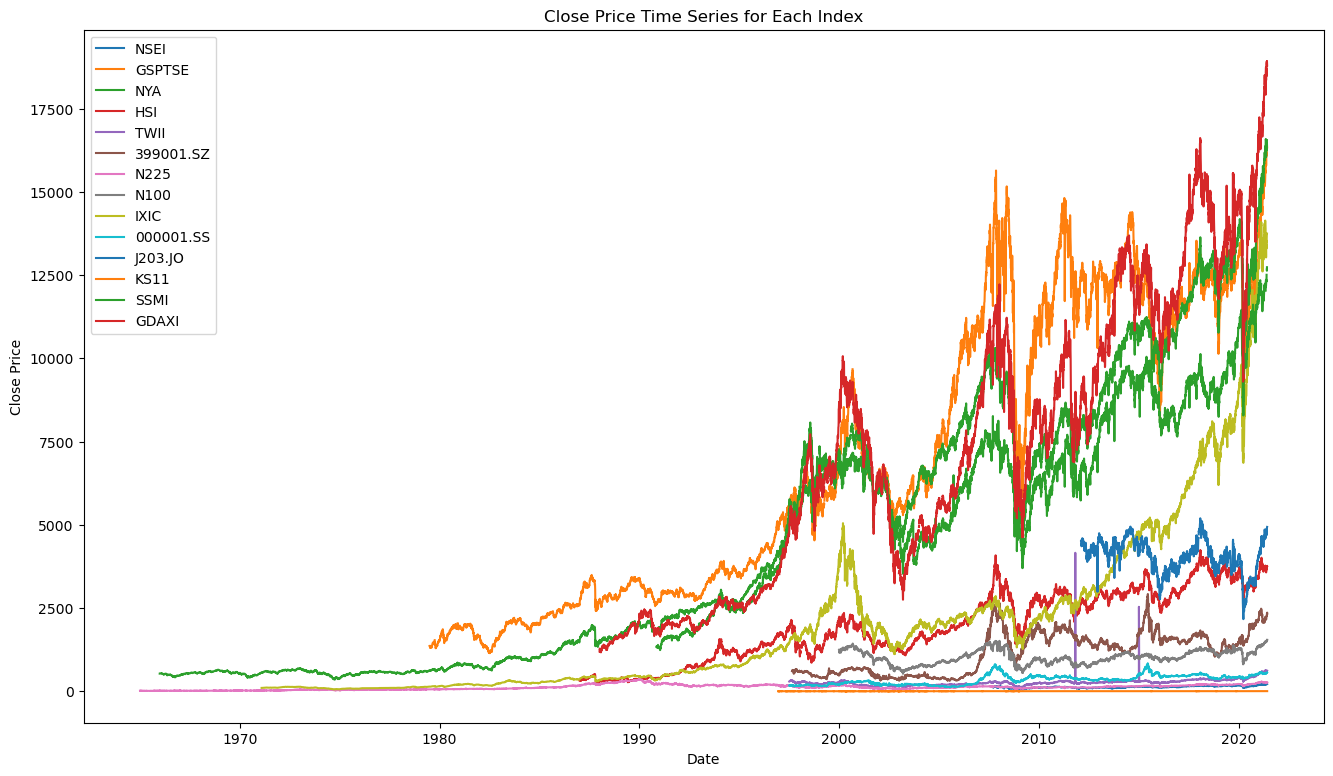

In [47]:
# Collect distinct indices
indices = [row.Index for row in usd_final_data.select("Index").distinct().collect()]

# Plot Close price time series for each index
plt.figure(figsize=(16, 9))  # Adjust width and height as needed

for index in indices:
    index_data = usd_final_data.filter(F.col("Index") == index).orderBy("Date").select("Date", "USD_Close").collect()
    dates = [row.Date for row in index_data]
    close_prices = [row.USD_Close for row in index_data]
    plt.plot(dates, close_prices, label=index)

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price Time Series for Each Index")
plt.legend()
plt.show()


4 4 16


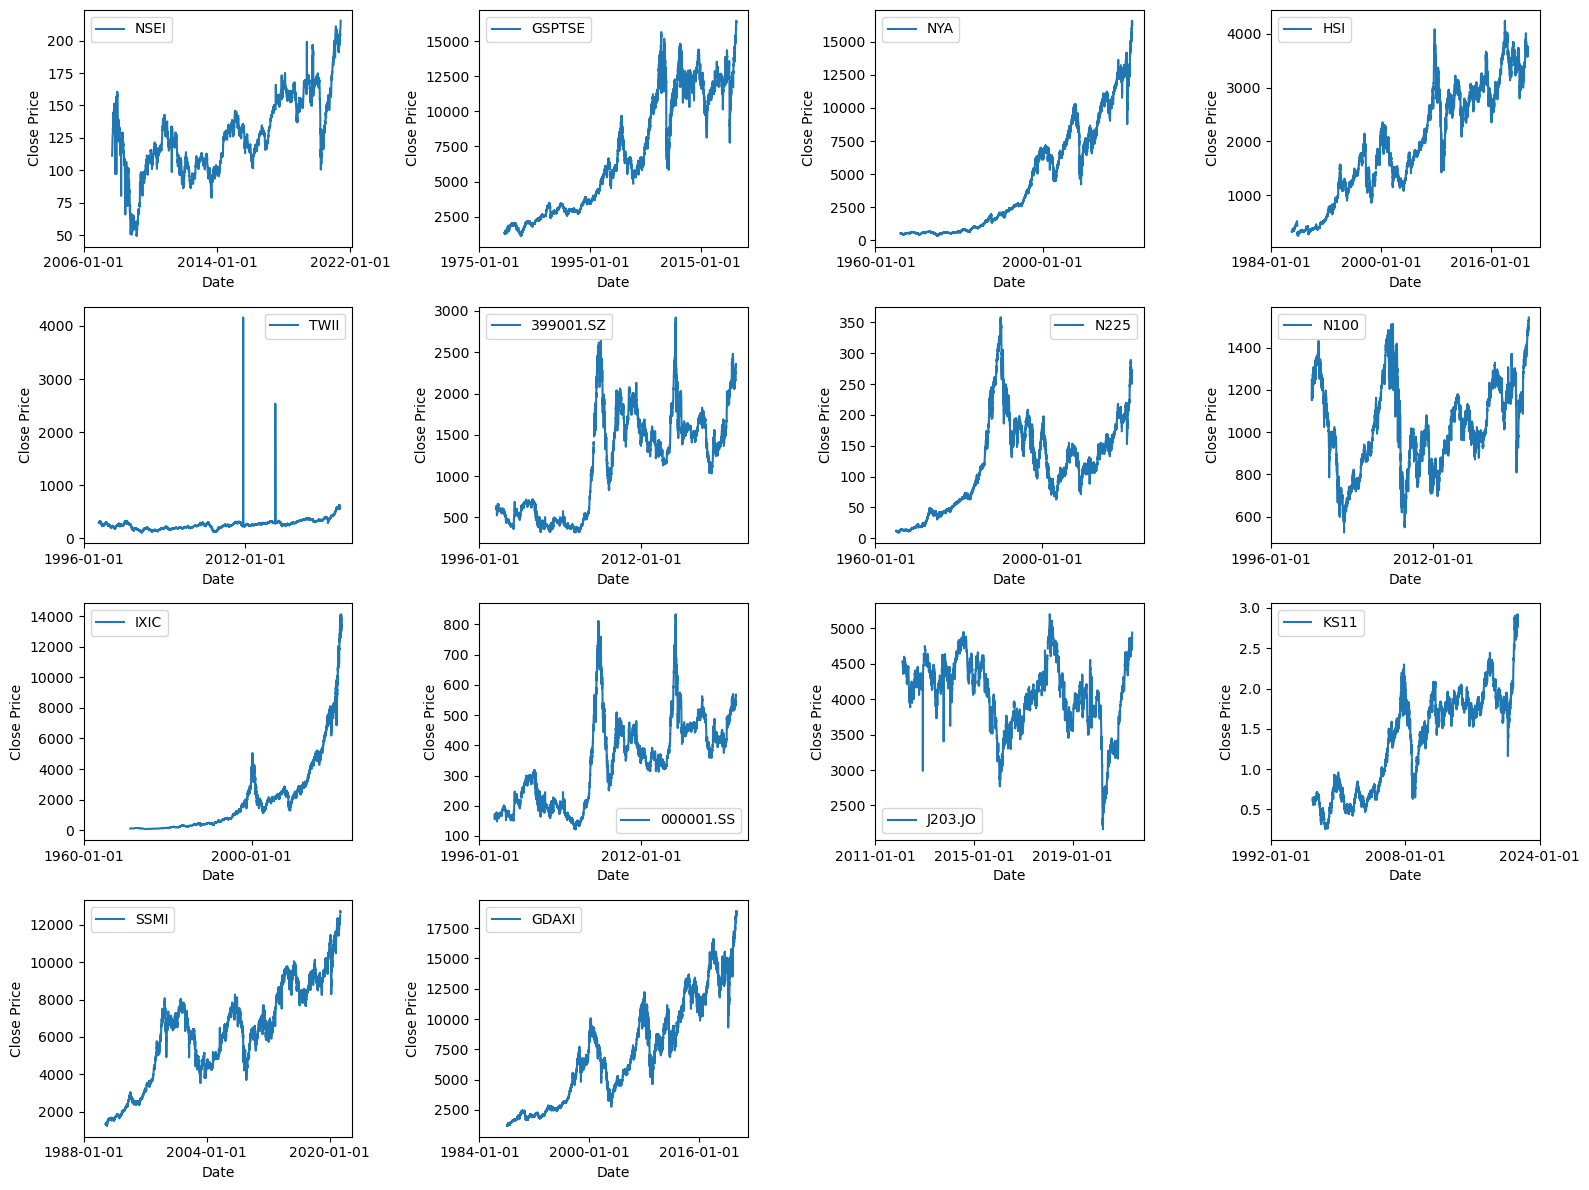

In [32]:
# Collect distinct indices
import numpy as np
indices = [row.Index for row in usd_final_data.select("Index").distinct().collect()]
numCols = 4
numRows = len(indices)//numCols + 1
n = numCols * numRows
print(numRows, numCols, n)
# Plot Close price time series for each index
# plt.figure(figsize=(numRows, numCols))  # Adjust width and height as needed
plt.figure(1, figsize=(16,12))  # Adjust width and height as needed
i = 1
for index in indices:
    index_data = usd_final_data.filter(F.col("Index") == index).orderBy("Date").select("Date", "USD_Close").collect()
    dates = [row.Date for row in index_data]
    close_prices = [row.USD_Close for row in index_data]
    plt.subplot(numRows, numCols, i)
    plt.plot(dates, close_prices, label=index)
    plt.xlabel("Date")
    plt.xticks(plt.xticks()[0][::4])
    plt.ylabel("Close Price")
    plt.legend()
    i+=1
    
# plt.figure(1)
plt.tight_layout()
# plt.title("Close Price Time Series for Each Index")
plt.show()